# Evaluating GSAT Score on Multiple Chinese LLM

In [25]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [26]:
dataset_df = pd.read_csv("./full-dataset-info.csv")
dataset_df.head()

,dataset_name,path,1_tile,2_tile,3_tile,4_tile,5_tile
0,113-ch,../dataset/gsat/113_chinese.csv,63.48,58.19,52.90,42.32,37.03
1,112-ch,../dataset/gsat/112_chinese.csv,62.63,57.41,52.19,41.75,36.54
2,111-ch,../dataset/gsat/111_chinese.csv,64.08,58.74,48.06,42.72,32.04
3,110-ch,../dataset/gsat/110_chinese.csv,64.57,59.19,53.81,43.05,37.67
4,109-ch,../dataset/gsat/109_chinese.csv,65.65,65.65,54.71,43.77,38.30


In [27]:
model_df = pd.read_csv("./full-model-info.csv")
model_df.head()

,model,short_name,open,zh-tw
0,ikala/bloom-zh-3b-chat,bloom-3b,True,True
1,taide/Llama3-TAIDE-LX-8B-Chat-Alpha1,taide-8b,True,True
2,MediaTek-Research/Breeze-7B-32k-Instruct-v1_0,breeze-7b,True,True
3,Qwen/Qwen1.5-1.8B-Chat,qwen-1.8b,True,False
4,Qwen/Qwen1.5-4B-Chat,qwen-4b,True,False


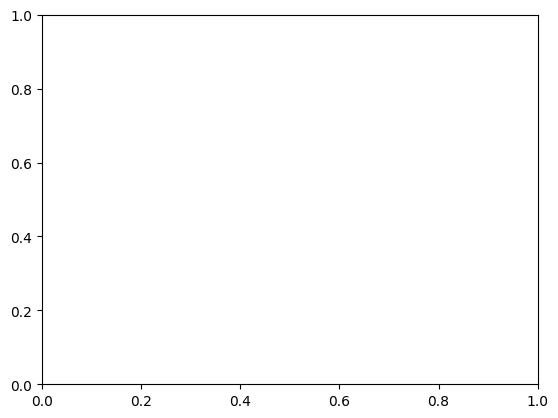

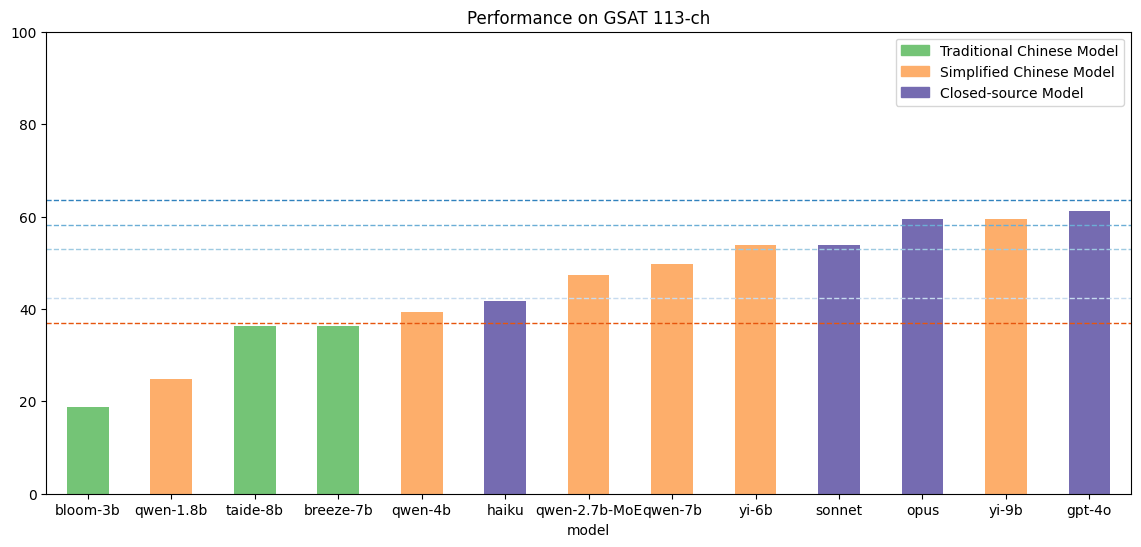

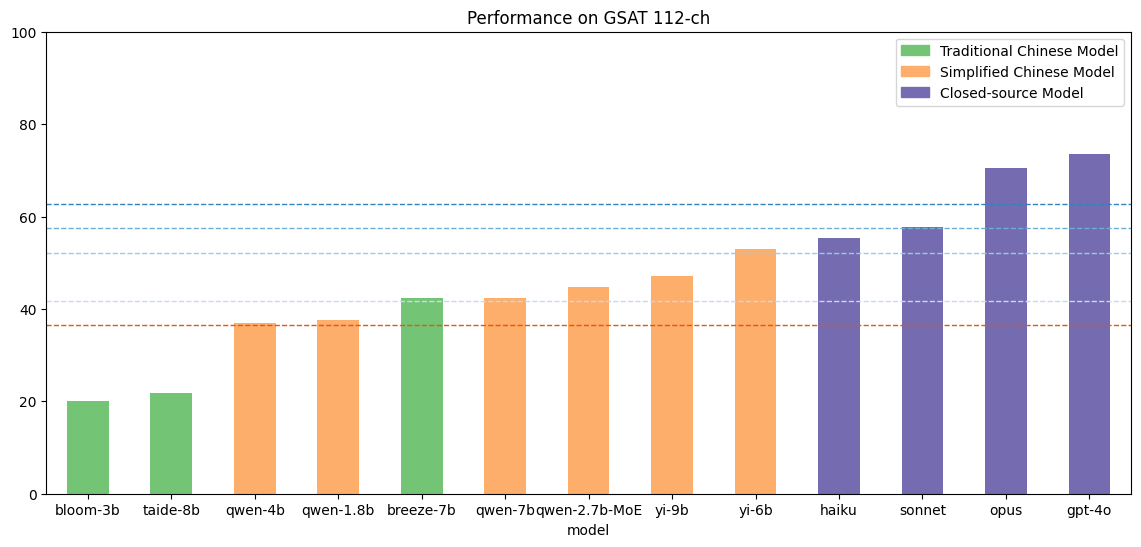

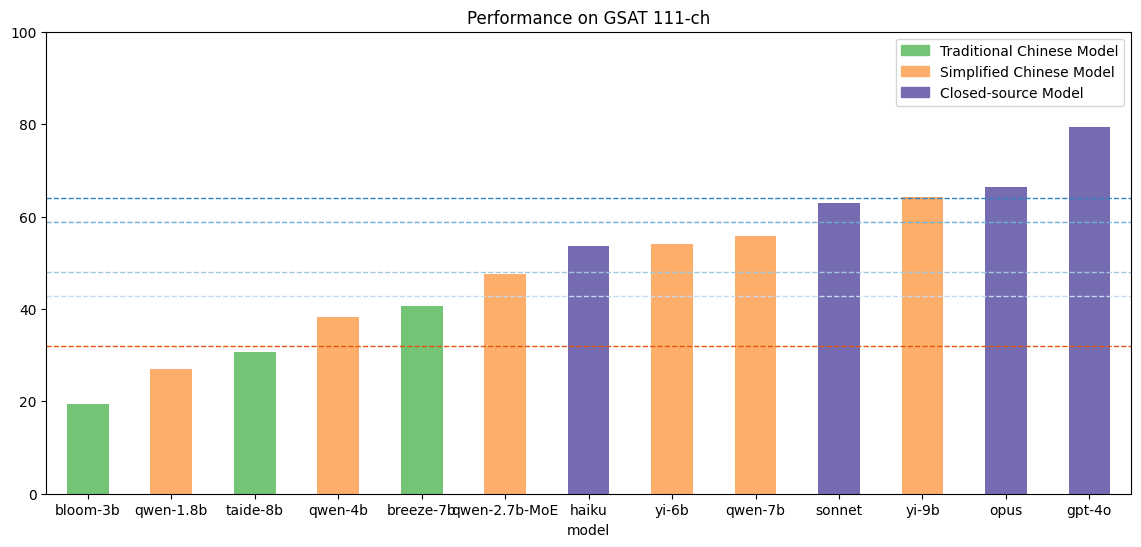

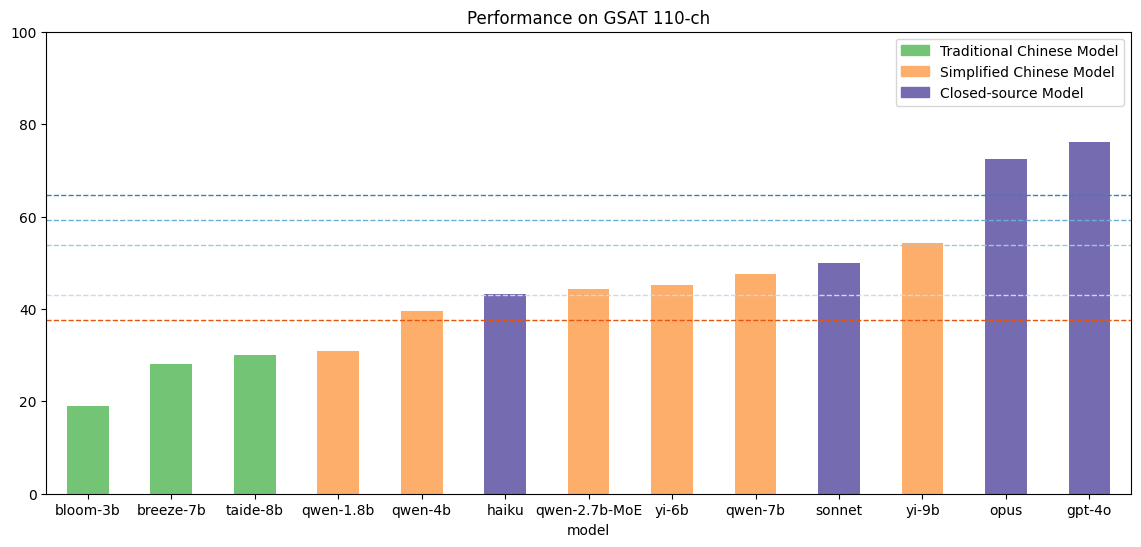

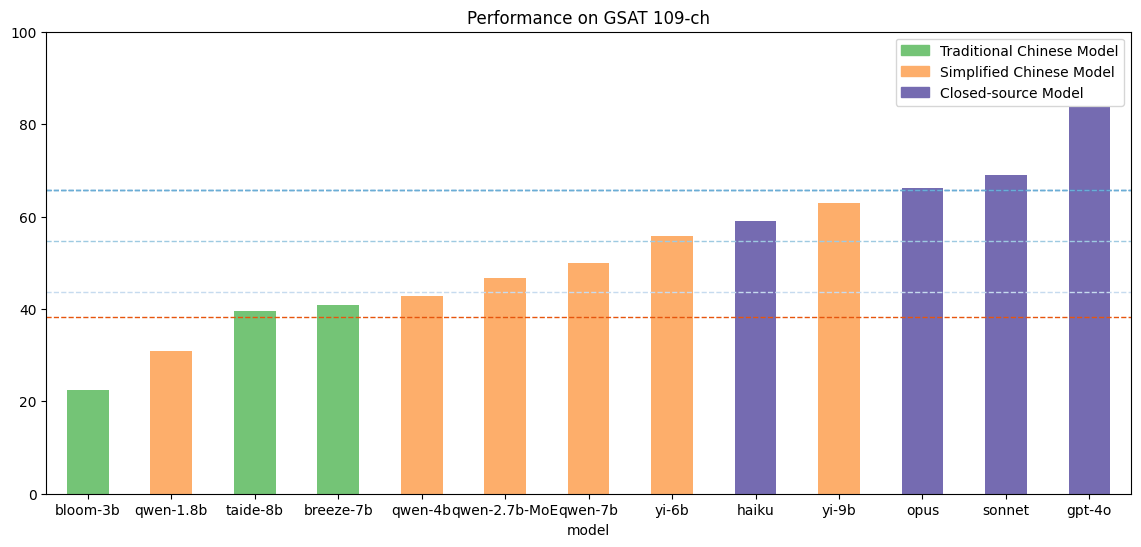

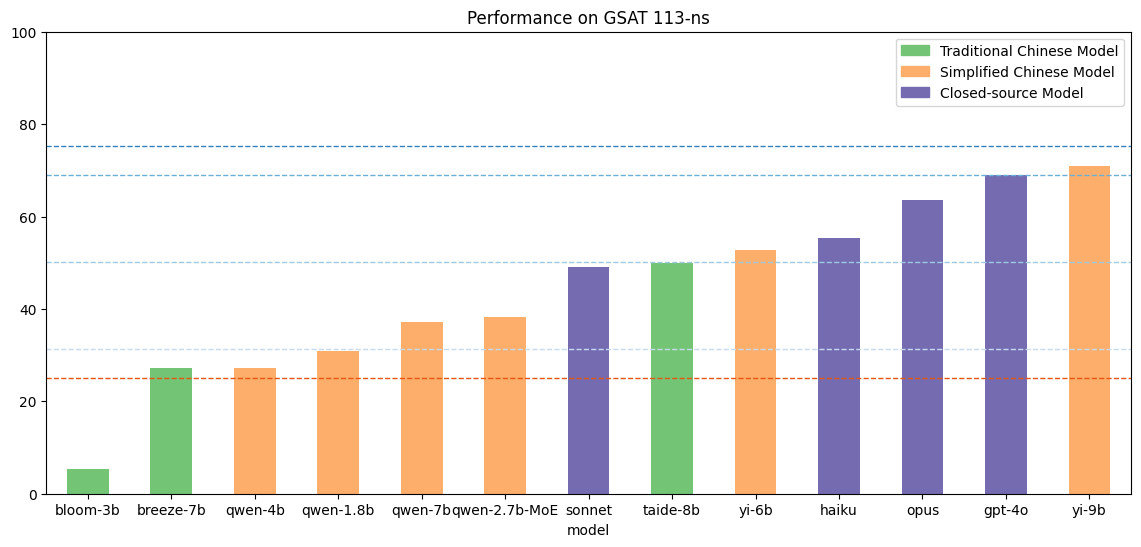

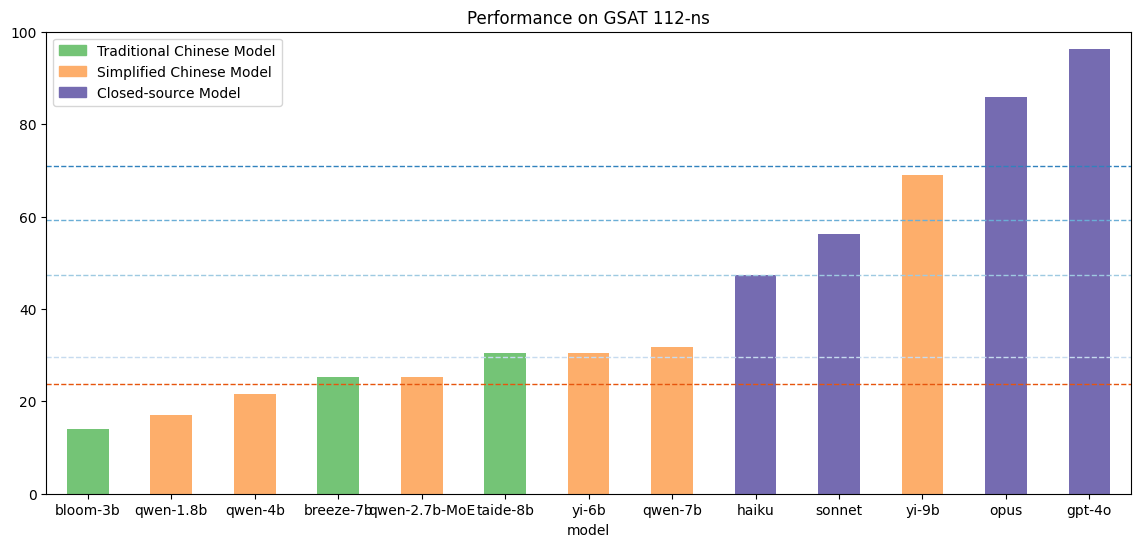

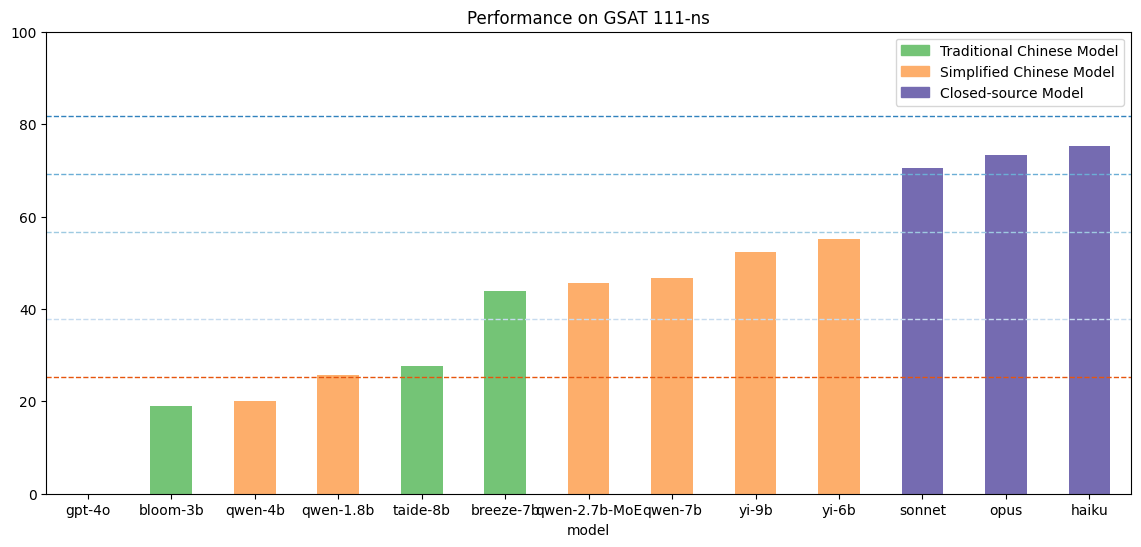

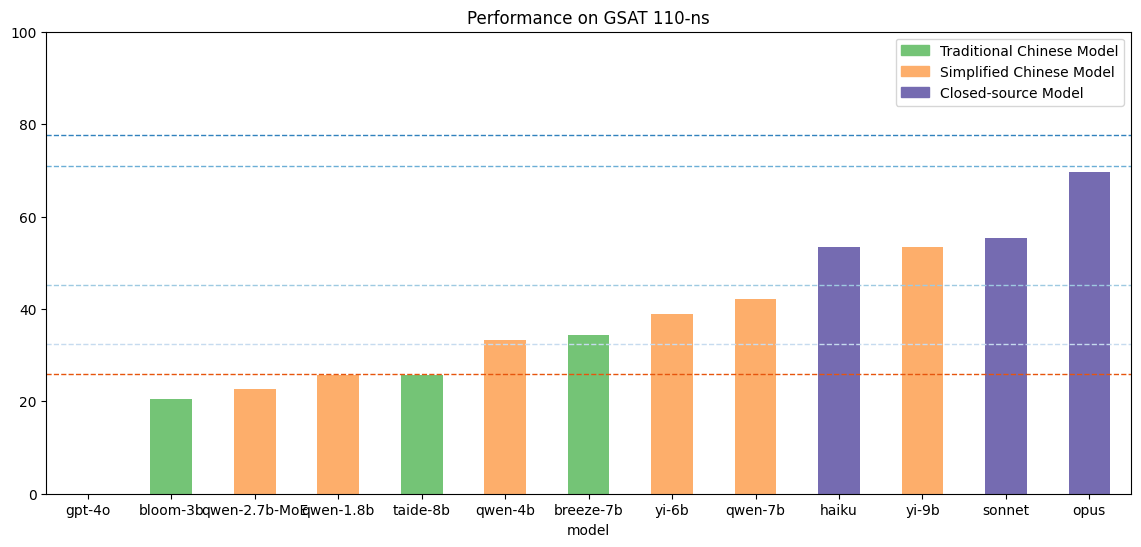

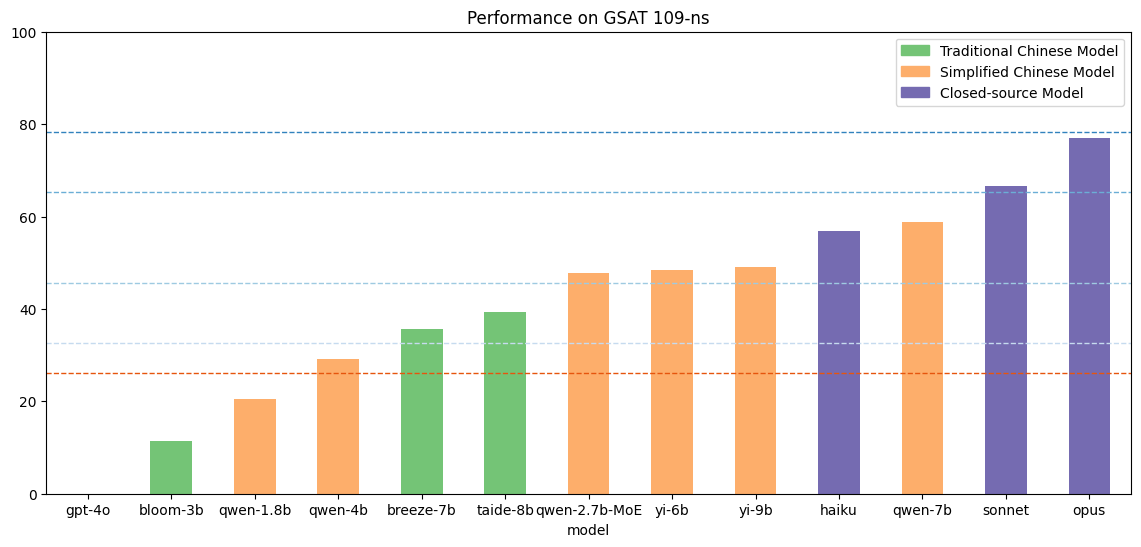

In [28]:
for test_name in dataset_df["dataset_name"].values.tolist():
    dataset_row = dataset_df[dataset_df["dataset_name"] == test_name]
    scores = []
    # dataset_df.where(dataset_df["dataset_name"]==test_name)["path"].values[0]
    for _ , model in model_df.iterrows():
        try:
            model_test_df = pd.read_csv(f'./{test_name}-result-{model["short_name"]}.csv')
            scores.append(model_test_df["score"].sum())
        except:
            scores.append(0.0)

    model_df["score"] = scores
    model_df["score"] /= len(pd.read_csv(dataset_row["path"].values[0]).index)
    model_df["score"] *= 100
    model_df = model_df.sort_values(["score"])
    cm = matplotlib.colormaps.get_cmap("tab20c")
    model_df.plot.bar(x='short_name', y='score', rot=0 , title=f"Performance on GSAT {test_name}" , xlabel="model",figsize=(14,6) , color=[cm.colors[12] if model["open"] is False else (cm.colors[9] if model["zh-tw"] is True else cm.colors[6]) for _,  model in model_df.iterrows() ] ,legend = False,ylim = [0,100])
    plt.axhline(y=dataset_row["1_tile"].values[0],linewidth=1,ls="--" ,color=cm.colors[0], label="12th")
    plt.axhline(y=dataset_row["2_tile"].values[0],linewidth=1,ls="--" ,color=cm.colors[1],label="25th")
    plt.axhline(y=dataset_row["3_tile"].values[0],linewidth=1,ls="--" ,color=cm.colors[2], label="50th")
    plt.axhline(y=dataset_row["4_tile"].values[0],linewidth=1,ls="--" ,color=cm.colors[3], label="75th")
    plt.axhline(y=dataset_row["5_tile"].values[0],linewidth=1,ls="--" ,color=cm.colors[4], label="88th")

    tw = mpatches.Patch(color=cm.colors[9], label='Traditional Chinese Model')
    cn = mpatches.Patch(color=cm.colors[6], label='Simplified Chinese Model')
    cs = mpatches.Patch(color=cm.colors[12], label='Closed-source Model')
    plt.legend(handles=[tw , cn , cs])
    plt.subplot()